In [73]:
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import seaborn as sns
import sklearn.cross_validation as cv
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor,export_graphviz
from DecisionTree import DecisionTree
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import GradientBoostingRegressor as GBR
from GradientBoosting import GradientBoosting as myGB
# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
FOLDER = "data/"
FILES = [
        "iris.txt", "bezdekIris.txt", "wine.txt", "bupa.txt", "housing.txt", "auto-mpg.txt", "spam"
        ]
FILE = "spam"

In [3]:
# Подготавливаем признаки и целевую функцию
if FILE in FILES[:6]:
    
    df = pd.read_csv(FOLDER+FILE, sep=",", header=None)#, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)
    
    if FILE in FILES[:2]:
        # ИРИСЫ
        df[4] = pd.factorize(df[4])[0]
        X = df[[0,1,2,3]].as_matrix()
        y = df[4].as_matrix()

    if FILE == FILES[2]:
        x_indexes = [x for x in range(1,14)]
        X = df[x_indexes].as_matrix()
        y = df[0].as_matrix()

    if FILE == FILES[3]:
        X = df[[0,1,2,3,4,5]].as_matrix()
        y = df[6]
        
    if FILE == FILES[4]:
        df = pd.read_csv(FOLDER+FILE, sep=" ", header=None)#, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)
        X = df[df.columns[1:]].as_matrix()
        y = df[df.columns[0]].as_matrix()
        
    if FILE == FILES[5]:
        df = pd.read_csv(FOLDER+FILE, sep=" ", header=None)#, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)
        X = df[df.columns[1:-1]].as_matrix()
        y = df[df.columns[0]].as_matrix()
        
    x_train, x_test, y_train, y_test = cv.train_test_split(X, y, test_size=0.25)

else:
    
    df_train = pd.read_csv(FOLDER+FILE+".train.txt", sep=" ", header=None)#, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)
    df_test = pd.read_csv(FOLDER+FILE+".test.txt", sep=" ", header=None)#, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)
    x_train = df_train[df_train.columns[1:]].as_matrix()
    y_train = df_train[df_train.columns[0]].as_matrix()
    x_test = df_test[df_test.columns[1:]].as_matrix()
    y_test = df_test[df_test.columns[0]].as_matrix()

In [89]:
def plot_curve(x, y, title):
    
    fig = plt.figure(figsize=(10, 10))
    plt.plot(x, y, color='blue', label='MyGB')
    plt.ylim(0, max(y*1.03)+0.02)
    plt.grid(True)
    plt.xlabel("features count", fontsize=15)
    plt.ylabel("mse", fontsize=15)
    plt.title(title)
    plt.legend()
    #plt.show()
    return

## Сколько фичей отбираем 

## Embedded 

In [19]:
N = 40

In [75]:
n_est=250
max_depth=4
rsm=False
shrinkage=0.1

In [ ]:
%%time
my_gb = myGB(n_estimators=n_est, max_depth=max_depth, rsm=rsm, shrinkage=shrinkage)
my_gb.fit(x_train, y_train)
y_predict = my_gb.predict(x_test)
print mse(y_test, y_predict)

In [17]:
def aggregate_gains(node, feature_importance):
    if node.is_leaf:
        return
    
    gain = node.predicate.gain
    feature_index = node.predicate.feature_id
    feature_importance[feature_index] = gain
    
    aggregate_gains(node.left_node, feature_importance)
    aggregate_gains(node.right_node, feature_importance)

In [41]:
feature_importance = np.zeros(len(x_train.T))
ensamble = my_gb._estimators
for tree in ensamble:
    aggregate_gains(tree._root, feature_importance)

In [42]:
zipped = zip(feature_importance, df_train.columns[1:])
zipped.sort(key = lambda t: t[0], reverse=True)
zipped[:N]

[(0.02446473706723961, 1),
 (0.011167097437227878, 5),
 (0.0029132725641669217, 3),
 (0.002127789661582192, 16),
 (0.0020445276193503431, 12),
 (0.0011988979992720132, 20),
 (0.0005115835275210361, 10),
 (0.00033454494933643356, 19),
 (0.00033154612640215074, 15),
 (0.00031486538366250812, 2),
 (0.00027328513892110884, 6),
 (0.00025020968288798654, 4),
 (7.0728926702270413e-05, 18),
 (3.9003940872655088e-05, 17),
 (3.8331850913073465e-05, 8),
 (3.3355779982461101e-05, 13),
 (3.2217514214449849e-05, 14),
 (2.7468813497631347e-05, 9),
 (2.0303530676989926e-05, 11),
 (1.7195524337910995e-05, 7),
 (0.0, 21),
 (0.0, 22),
 (0.0, 23),
 (0.0, 24),
 (0.0, 25),
 (0.0, 26),
 (0.0, 27),
 (0.0, 28),
 (0.0, 29),
 (0.0, 30)]

#### Посчитаем качество на сокращенном наборе фичей

In [18]:
new_features = []
for i in range(N):
    new_features.append(zipped[i][1]-1)
    
new_x_train = x_train[:,new_features]

NameError: name 'zipped' is not defined

In [32]:
%%time
my_gb = myGB(n_estimators=n_est, max_depth=max_depth, rsm=rsm, shrinkage=shrinkage)
my_gb.fit(new_x_train, y_train)
y_predict = my_gb.predict(x_test)
print mse(y_test, y_predict)

0.322692170533
CPU times: user 13min 27s, sys: 2.22 s, total: 13min 29s
Wall time: 13min 28s


#### Сравним качество со Sklearn'ом 

In [36]:
gb = GradientBoostingRegressor(n_estimators=250)
gb.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=250,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [37]:
zipped = zip(gb.feature_importances_, df_train.columns[1:])
zipped.sort(key = lambda t: t[0], reverse=True)

[(0.042212281145185708, 49),
 (0.032436520263697421, 102),
 (0.032229981494934584, 5),
 (0.029505360193011251, 36),
 (0.026928207878023327, 54),
 (0.026414410156935377, 10),
 (0.025565967771776561, 44),
 (0.025262875587349139, 16),
 (0.024399274792146423, 30),
 (0.022949277322286958, 32),
 (0.022690757875864397, 50),
 (0.022537785499465571, 72),
 (0.021377374063986553, 9),
 (0.018091260746360575, 71),
 (0.017762623267217809, 38),
 (0.017020544915766954, 39),
 (0.01532870021530928, 94),
 (0.015226564297827365, 4),
 (0.015214750487401049, 25),
 (0.014908850581864499, 42)]

In [38]:
new_features = []
for i in range(N):
    new_features.append(zipped[i][1]-1)
    
new_x_train = x_train[:,new_features]

In [39]:
gb = GradientBoostingRegressor(n_estimators=250)
gb.fit(new_x_train, y_train)
y_predict = my_gb.predict(x_test)
print mse(y_test, y_predict)

0.322692170533


# Filtering

#### Считаем дисперсию. Удаляем фичи с малой дисперсией

In [90]:
zipped_var = zip(np.var(x_train, axis=1), df_train.columns[1:])
zipped_var.sort(key = lambda t: t[0], reverse=False)
zipped_var[:N]

[(0.0076567972880058569, 64),
 (0.0076716236387681224, 65),
 (0.011695836204174997, 40),
 (0.011856509800414342, 71),
 (0.011979800781408386, 60),
 (0.012334360744794213, 13),
 (0.01252989273047095, 47),
 (0.01280339659541937, 1),
 (0.013210705078223866, 46),
 (0.013240534094942073, 29),
 (0.01334082804030908, 4),
 (0.013522356747637595, 57),
 (0.013933084360454307, 37),
 (0.013961477804628213, 26),
 (0.014248337305146784, 50),
 (0.014808084850882801, 2),
 (0.014840618193294816, 35),
 (0.014956189589553484, 39),
 (0.015313791703047483, 30),
 (0.015640209719890268, 51),
 (0.01572107353262182, 27),
 (0.016021380299304628, 38),
 (0.016037463097568035, 48),
 (0.01605004425878238, 3),
 (0.016109212439741588, 36),
 (0.01626126579486804, 11),
 (0.016381139588248619, 81),
 (0.016417947861641212, 45),
 (0.016427802200562083, 31),
 (0.016547599623142114, 59),
 (0.016702966140811727, 10),
 (0.01714869918210029, 15),
 (0.017350723301227645, 68),
 (0.017635796918884304, 20),
 (0.017644749010785932,

#### Считаем корреляцию

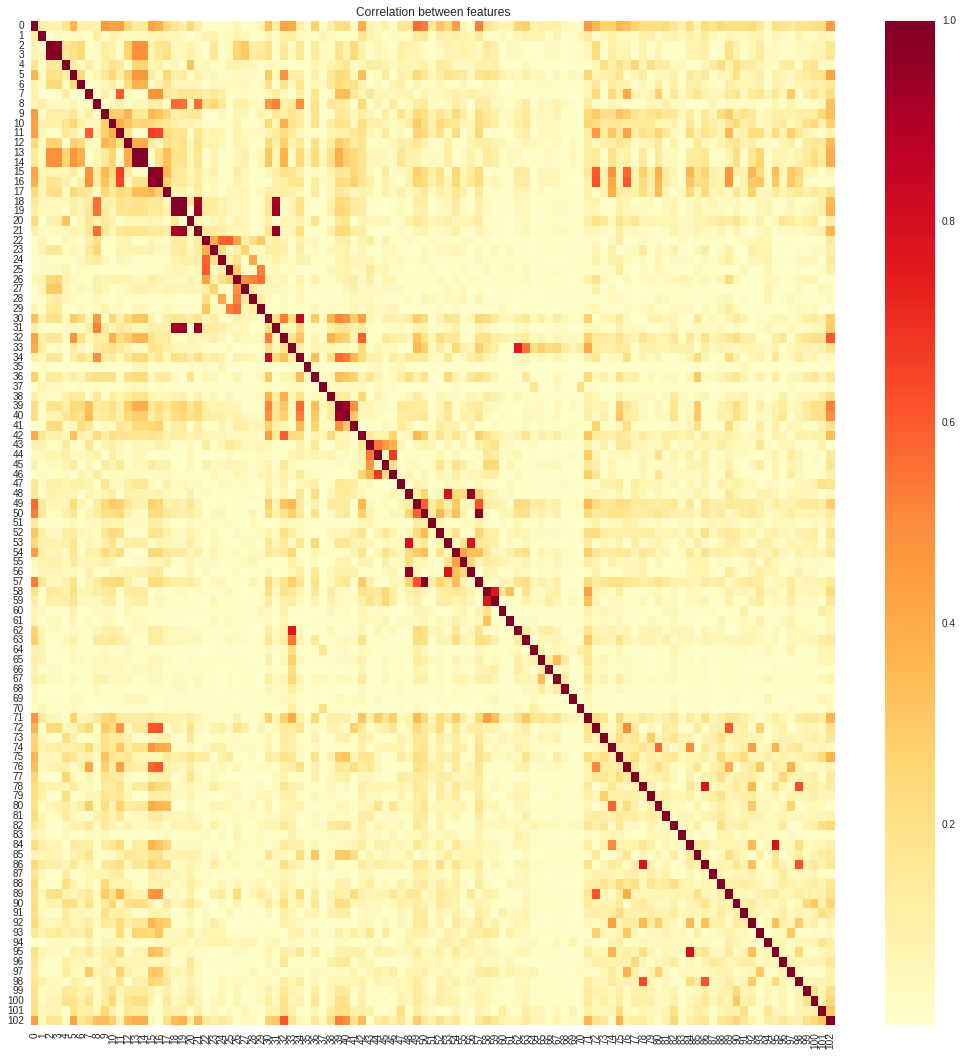

In [91]:
corr_mat = df_train.corr().abs()
plt.figure(figsize=(18, 18))
plt.title("Correlation between features")
sns.heatmap(corr_mat, cmap="YlOrRd")

In [92]:
# Выберем признаки, похожие на ответ
abs_corr_y = corr_mat[0]
good_features = abs_corr_y.sort_values(ascending=False)[:N]
good_features

0      1.000000
49     0.568761
57     0.537859
50     0.528454
71     0.471797
9      0.457633
102    0.449326
11     0.438617
54     0.438501
10     0.426603
32     0.426160
15     0.424721
42     0.400683
33     0.394837
16     0.383547
72     0.361224
5      0.360705
75     0.356101
30     0.331017
76     0.328774
52     0.310010
63     0.277489
74     0.273313
36     0.268448
77     0.268415
73     0.265625
62     0.257104
53     0.252628
17     0.247948
88     0.245494
12     0.243380
86     0.237652
20     0.236205
92     0.235714
84     0.230141
40     0.227601
79     0.224334
78     0.223807
81     0.223653
90     0.218516
Name: 0, dtype: float64

#### Найдем признаки, которых похожи на те, что мы отобрали. Их не берем

In [93]:
min_cor = 0.7
feature_indexes = good_features.index
full_similar_features = []
for idx in feature_indexes:
    similiar_features = corr_mat[corr_mat[idx]>min_cor].index.values
    # Удаляем значение idx из similiar_features
    similiar_features = similiar_features[similiar_features != idx]
    full_similar_features.extend(similiar_features)
    print "Feature ", idx, " correlate with ", similiar_features
    
print full_similar_features

Feature  0  correlate with  []
Feature  49  correlate with  []
Feature  57  correlate with  [50]
Feature  50  correlate with  [57]
Feature  71  correlate with  []
Feature  9  correlate with  []
Feature  102  correlate with  []
Feature  11  correlate with  []
Feature  54  correlate with  []
Feature  10  correlate with  []
Feature  32  correlate with  []
Feature  15  correlate with  [16]
Feature  42  correlate with  []
Feature  33  correlate with  [62]
Feature  16  correlate with  [15]
Feature  72  correlate with  []
Feature  5  correlate with  []
Feature  75  correlate with  []
Feature  30  correlate with  [34]
Feature  76  correlate with  []
Feature  52  correlate with  []
Feature  63  correlate with  []
Feature  74  correlate with  []
Feature  36  correlate with  []
Feature  77  correlate with  []
Feature  73  correlate with  []
Feature  62  correlate with  [33]
Feature  53  correlate with  [48 56]
Feature  17  correlate with  []
Feature  88  correlate with  []
Feature  12  correlate 

In [94]:
for f in full_similar_features:
    if f in good_features:
        good_features = good_features.drop(f)

In [95]:
good_features = list(good_features.index[1:]-1)

In [96]:
# чтобы не потерять
print good_features

[48, 70, 8, 101, 10, 53, 9, 31, 41, 71, 4, 74, 29, 75, 51, 62, 73, 35, 76, 72, 52, 16, 87, 11, 19, 91, 83, 39, 78, 80, 89]


In [79]:
mse_array=[]
for i in range(1, len(good_features)+1):
    features = good_features[:i]
    X_train, X_test = x_train[:,features], x_test[:, features]
    model = GBR(n_estimators=n_est, max_depth=max_depth, learning_rate=shrinkage)
    model.fit(X_train, y_train)
    y_predicted=model.predict(X_test)
    mse_array.append(mse(y_test, y_predicted))

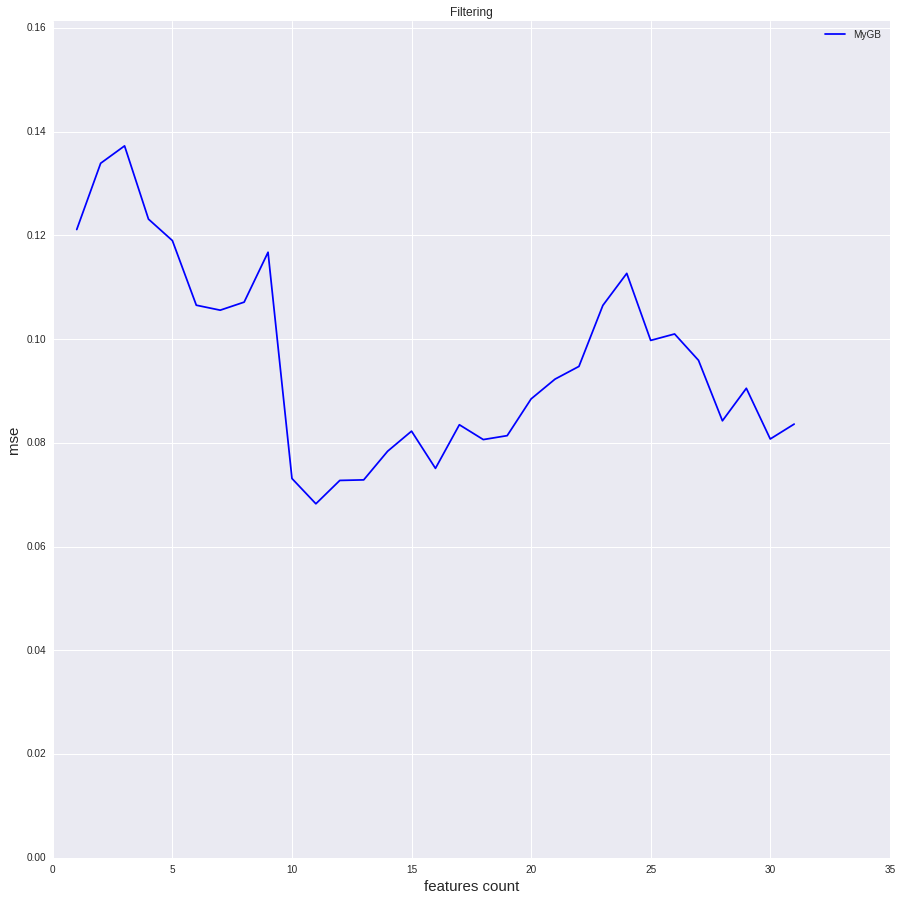

In [85]:
plot_curve(range(1, len(good_features)+1), np.asarray(mse_array), "Filtering")

# Wrapper

In [103]:
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import GradientBoostingRegressor as GBR

In [104]:
n_est=250
rsm=False
shrinkage=0.1
max_depth=4

In [105]:
def measure_quality(X, y, k=3):
    
    kf = KFold(len(y), n_folds=k)
    mse_array = []
    for train, test in kf:
        _X_train, _X_test, _y_train, _y_test = X[train], X[test], y[train], y[test]
        model = GBR(n_estimators=n_est, max_depth=max_depth, learning_rate=shrinkage)
        model.fit(_X_train, _y_train)
        _y_predicted=model.predict(_X_test)
        mse_array.append(mse(_y_test, _y_predicted))
    
    return float(sum(mse_array))/len(mse_array)

In [106]:
def find_best_feature(best_features, remaining_features, x_train, y_train):
    """
    Выбираем лучшую фичу.
    best_features - [1,5,10,...]фичи, которые уже были выбраны
    remaining_features - [2,3,4,6,7,8,9,,...] оставшиеся фичи, которые уже были выбраны
    """
    best_mse = sys.maxint
    best_fea = None
    print best_features, remaining_features

    for f in remaining_features:
        new_features = best_features + [f]
        print new_features
        new_mse = measure_quality(x_train[:,new_features], y_train)
        
        if new_mse < best_mse:
            best_mse = new_mse
            best_fea = f
            
    return best_fea, best_mse

In [ ]:
%%time
best_features=[]

all_features=range(0, x_train.shape[1])
print x_train.shape[1]
best_mse=sys.maxint

for f in all_features:
    feature, cur_mse = find_best_feature(best_features, all_features, x_train, y_train)
    
    if cur_mse<best_mse:
        print "===================="
        print "new_best_mse = ", cur_mse
        best_mse=cur_mse
        best_features.append(feature)
        all_features.remove(feature)
        print "the_best_feature_list=", best_features
        print all_features
        print "////////////////"
    else:
        print "NOT_GOOD_FEATURES"
        break

102
[] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101]
[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]
[11]
[12]
[13]
[14]
[15]
[16]
[17]
[18]
[19]
[20]
[21]
[22]
[23]
[24]
[25]
[26]
[27]
[28]
[29]
[30]
[31]
[32]
[33]

In [97]:
good_features = [48, 70, 53, 10, 101, 56, 55, 9, 71, 4, 76, 52, 16, 3, 6, 50, 65, 100]

mse_array=[]
for i in range(1, len(good_features)+1):
    features = good_features[:i]
    X_train, X_test = x_train[:,features], x_test[:, features]
    model = GBR(n_estimators=40, max_depth=max_depth, learning_rate=shrinkage)
    model.fit(X_train, y_train)
    y_predicted=model.predict(X_test)
    mse_array.append(mse(y_test, y_predicted))

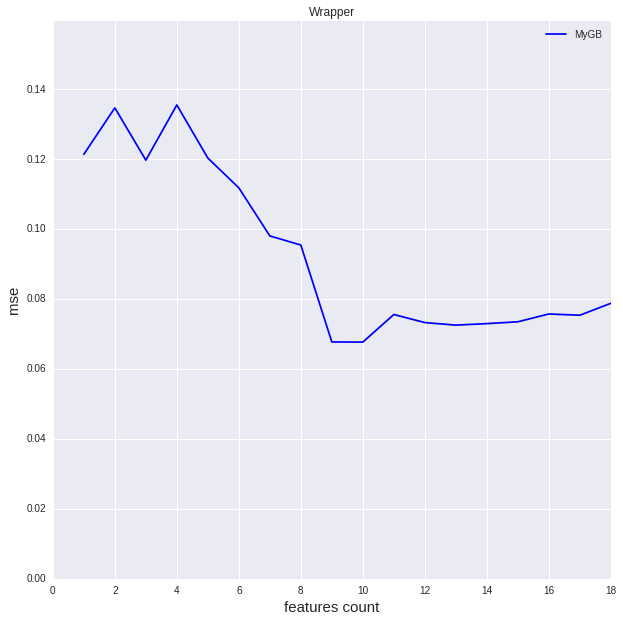

In [98]:
plot_curve(range(1, len(good_features)+1), np.asarray(mse_array), "Wrapper")